In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('price_list_data.csv')
df.drop(columns='Unnamed: 0', inplace=True)

구를 인코딩합니다.

In [3]:
df['Gu_encoding'] = df['Gu'].astype('category').cat.codes + 1
df['Gu_encoding'] = df['Gu_encoding'].astype('int64')

In [4]:
Q1 = df['Price per Area'].quantile(0.25)
Q3 = df['Price per Area'].quantile(0.75)
IQR = Q3 - Q1

# IQR을 이용해서 이상치를 구합니다
outliers = df['Price per Area'][((df['Price per Area'] < (Q1 - 1.5 * IQR)) |(df['Price per Area'] > (Q3 + 1.5 * IQR)))]
outliers.count()

7972

이상치 수가 전체(약 18만)에 비해서 많지 않고, 실제 데이터인만큼 이상치는 따로 처리하지 않습니다.

In [5]:
df.columns

Index(['Date', 'Name', 'Year', 'Month', 'Gu', 'Dong', 'Address', 'Longitude',
       'Latitude', 'major', 'Building Year', 'Floor', 'Actual Price Index',
       'Living Price Index', 'Interest Rate', 'Jeonse Index', 'Price', 'Area',
       'Price per Area', 'Price per Area Log Scale', 'Total Population',
       'Children', 'Adolescent', 'Youth', 'Middle-Aged', 'Old Age',
       'Consumption', 'Nearest Medical Center', 'Distance to MC',
       'Nearest Station', 'Distance to NS', 'Elementary Schools Num',
       'High Schools Num', 'Market Num', 'Hospital Num', 'Park Presence',
       'Nearby Hangang', 'Bus Station', 'Gu_encoding'],
      dtype='object')

In [14]:
X = df[['Date','Year', 'Month', 'Longitude',
       'Latitude', 'major', 'Building Year', 'Floor', 'Actual Price Index',
       'Living Price Index', 'Interest Rate', 'Jeonse Index', 'Total Population',
       'Children', 'Adolescent', 'Youth', 'Middle-Aged', 'Old Age',
       'Consumption', 'Distance to MC', 'Distance to NS', 'Elementary Schools Num',
       'High Schools Num', 'Market Num', 'Hospital Num', 'Park Presence',
       'Nearby Hangang', 'Bus Station', 'Gu_encoding']]
y = df['Price per Area']

VIF(다중공선성) 검사를 실행합니다.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X.astype(float)
X_const = add_constant(X) 

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif["features"] = X_const.columns

vif["VIF Factor"] = vif["VIF Factor"].apply(lambda x: '{:.0f}'.format(x))
vif

c:\Users\LSNAu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0,const
1,1844566,Date
2,3526,Year
3,1856558,Month
4,1,Longitude
5,2,Latitude
6,1,major
7,1,Building Year
8,1,Floor
9,8,Actual Price Index


VIF가 높은 수치가 많아서 이를 제거합니다. Date, Year,Month 제거. 'Living Price Index'제거. 'Children', 'Adolescent', 'Youth', 'Middle-Aged', 'Old Age',중 목표 변수와 상관관계가 가장 낮았던 'Adolescent', 'Middle-Aged'를 제거합니다.

In [18]:
X = df[['Longitude',
       'Latitude', 'major', 'Building Year', 'Floor', 'Actual Price Index', 'Interest Rate', 'Jeonse Index', 'Total Population',
       'Children', 'Youth', 'Old Age',
       'Consumption', 'Distance to MC', 'Distance to NS', 'Elementary Schools Num',
       'High Schools Num', 'Market Num', 'Hospital Num', 'Park Presence',
       'Nearby Hangang', 'Bus Station', 'Gu_encoding']]
y = df['Price per Area']

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X.astype(float)
X_const = add_constant(X) 

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif["features"] = X_const.columns

vif["VIF Factor"] = vif["VIF Factor"].apply(lambda x: '{:.0f}'.format(x))
vif

,VIF Factor,features
0,2385828,const
1,1,Longitude
2,2,Latitude
3,1,major
4,1,Building Year
5,1,Floor
6,1,Actual Price Index
7,10,Interest Rate
8,10,Jeonse Index
9,1,Total Population


모두 10 이하로 나온것을 볼 수 있습니다. 

In [20]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Price per Area   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     7633.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:37:17   Log-Likelihood:            -1.2203e+06
No. Observations:              162930   AIC:                         2.441e+06
Df Residuals:                  162906   BIC:                         2.441e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -3.197e+04   1657.951    -19.281      0.000   -3.52e+04   -2.87e+04
Longitude                964.7695     13.398     72.011      0.000     938.511     991.028
Latitude               -2443.7638     30.167    -81.009      0.000   -2502.890   -2384.638
major                     67.6013      1.313     51.498      0.000      65.028      70.174
Building Year              0.1872      0.005     35.304      0.000       0.177       0.198
Floor                      9.1966      0.179     51.342      0.000       8.846       9.548
Actual Price Index         7.9420      0.067    118.035      0.000       7.810       8.074
Interest Rate             23.2319      2.783      8.349      0.000      17.778      28.686
Jeonse Index              -6.0192      1.731     -3.478      0.001      -9.411      -2.627
Total Population           0.0002   2.17e-05      9.558      0.000       0.000       0.000
Children                4513.0277    103.101     43.773      0.000    4310.952    4715.103
Youth                   -860.2029     40.339    -21.324      0.000    -939.266    -781.140
Old Age                -1498.6965     67.977    -22.047      0.000   -1631.930   -1365.462
Consumption              197.5609      2.017     97.925      0.000     193.607     201.515
Distance to MC            15.8899      1.572     10.108      0.000      12.809      18.971
Distance to NS          -152.9641      2.579    -59.316      0.000    -158.018    -147.910
Elementary Schools Num    25.9397      0.993     26.136      0.000      23.994      27.885
High Schools Num          48.0707      1.036     46.404      0.000      46.040      50.101
Market Num                 5.9471      0.200     29.735      0.000       5.555       6.339
Hospital Num             -13.2151      0.204    -64.813      0.000     -13.615     -12.815
Park Presence             54.1592      8.430      6.425      0.000      37.637      70.681
Nearby Hangang           385.6604      5.383     71.642      0.000     375.110     396.211
Bus Station               -1.4570      0.264     -5.512      0.000      -1.975      -0.939
Gu_encoding                5.9191      0.178     33.212      0.000       5.570       6.268
==============================================================================
Omnibus:                    40105.496   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236970.245
Skew:                           1.056   Prob(JB):                         0.00
Kurtosis:                       8.518   Cond. No.                     1.45e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+08. This mi

In [ ]:
P밸류도 낮게 나왔습니다.

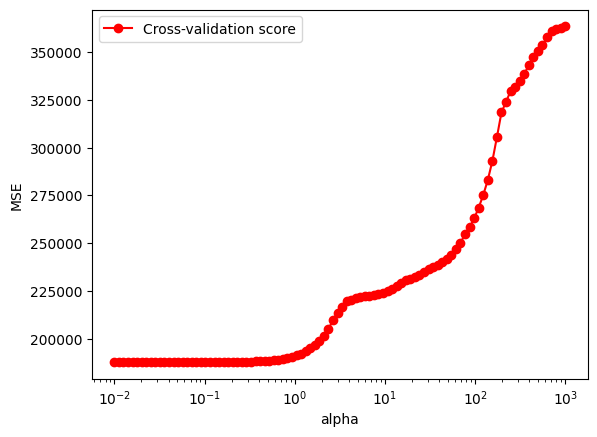

In [22]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

param_range = np.logspace(-2, 3, 100)

# validation_curve 함수를 사용하여 검증 곡선을 계산합니다.
train_scores, test_scores = validation_curve(
    Lasso(), X_train, y_train, param_name="alpha", param_range=param_range,
    scoring="neg_mean_squared_error", cv=5)

# 검증 곡선을 시각화합니다.
plt.plot(param_range, -test_scores.mean(1), 'o-', color="r", label="Cross-validation score")
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.xscale('log')
plt.legend()

In [25]:
X_train.drop(columns='const', inplace=True)

In [31]:

from sklearn.metrics import mean_squared_error

alpha = 1  # 위의 그래프를 보고 값을 지정합니다.
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

print(f'Selected features: {np.where(lasso_model.coef_ != 0)[0]}')

Mean Squared Error: 188135.11780717756
Selected features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


모든 변수를 선택하면 좋다는 결과가 나왔습니다.

다른 방법을 사용하기위해 전진선택법, 후진소거법, 교차선택법을 씁니다.

In [40]:
#전진선택법

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    aic_values = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_feature = new_pval.idxmin()
            best_features.append(best_feature)
            aic_values.append(sm.OLS(target, sm.add_constant(data[best_features])).fit().aic)
        else:
            break
    
    return best_features, aic_values

#후진소거법
def backward_elimination(data, target, significance_level = 0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:] 
        max_p_value = p_values.max()
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

#교차선택법
def stepwise_selection(data, target, SL_in=0.05, SL_out=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        changed=False
        # 전진 선택
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < SL_in:
            best_features.append(new_pval.idxmin())
            changed=True
        
        # 후진 소거
        model = sm.OLS(target, sm.add_constant(data[best_features])).fit()
        p_values = model.pvalues.iloc[1:]
        max_p_value = p_values.max()
        if max_p_value > SL_out:
            changed=True
            worst_feature = p_values.idxmax()
            best_features.remove(worst_feature)
        
        if not changed:
            break

    return best_features

In [41]:
selected_features_foward, aic_values = forward_selection(X_train, y_train, significance_level=0.05)
selected_features_foward

['major',
 'Children',
 'Old Age',
 'Bus Station',
 'Actual Price Index',
 'Longitude',
 'Latitude',
 'Consumption',
 'Youth',
 'Nearby Hangang',
 'Interest Rate',
 'Building Year',
 'Floor',
 'Hospital Num',
 'Elementary Schools Num',
 'Market Num',
 'Distance to NS',
 'High Schools Num',
 'Gu_encoding',
 'Distance to MC',
 'Total Population',
 'Park Presence',
 'Jeonse Index']

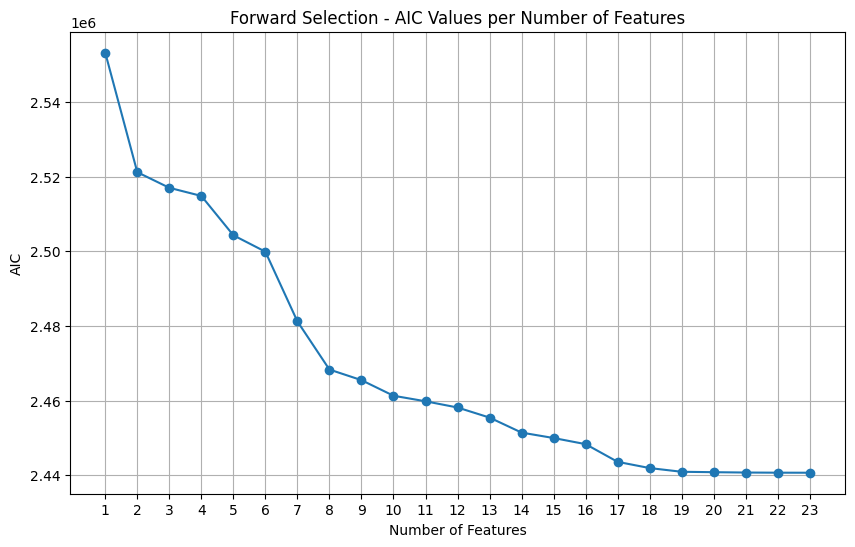

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(aic_values) + 1), aic_values, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('AIC')
plt.title('Forward Selection - AIC Values per Number of Features')
plt.xticks(range(1, len(aic_values) + 1))
plt.grid(True)
plt.show()

In [39]:
selected_features_backward = backward_elimination(X_train, y_train, significance_level=0.05)
selected_features_backward

['Longitude',
 'Latitude',
 'major',
 'Building Year',
 'Floor',
 'Actual Price Index',
 'Interest Rate',
 'Jeonse Index',
 'Total Population',
 'Children',
 'Youth',
 'Old Age',
 'Consumption',
 'Distance to MC',
 'Distance to NS',
 'Elementary Schools Num',
 'High Schools Num',
 'Market Num',
 'Hospital Num',
 'Park Presence',
 'Nearby Hangang',
 'Bus Station',
 'Gu_encoding']

In [43]:
stepwise_selection_features = stepwise_selection(X_train, y_train)
stepwise_selection_features

['major',
 'Children',
 'Old Age',
 'Actual Price Index',
 'Longitude',
 'Latitude',
 'Consumption',
 'Youth',
 'Nearby Hangang',
 'Interest Rate',
 'Building Year',
 'Floor',
 'Hospital Num',
 'Elementary Schools Num',
 'Market Num',
 'Distance to NS',
 'High Schools Num',
 'Gu_encoding',
 'Total Population',
 'Distance to MC',
 'Park Presence',
 'Bus Station',
 'Jeonse Index']

모든 결과, 더이상 변수를 소거하지 않아도 된다는 결론이 나왔습니다.

이제 모델링으로 넘어갑니다.